### Notes as I go:

 * I initialized Jupyter from my generic anaconda environment and received an error about a missing module; [this thread](https://forums.fast.ai/t/error-no-module-named-bcolz-but-bcolz-is-already-installed/9504/6) recommended updating conda and activating it from my wd: 
 
 ```
 cd /Documents/fastai 
 conda activate fastai
 jupyter notebook
 ```
 
 * I am keeping this notebook up-to-date as I proceed through the course by copying it from my working directory on my local machine, which may differ from my side projects directory that points to GitHub ('cautious_cauliflower').

# Random Forests

## Imports

In [7]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
from IPython.display import display

In [12]:
PATH = '/home/lindsay/Documents/fastai/courses/ml1/'

In [13]:
# check that this repository has what I need...
!ls {PATH}

00-DO-NOT-USE-WITH-FASTAI-1.0.x.txt  lesson2-rf_interpretation.ipynb
bulldozer_dl.ipynb		     lesson3-rf_foundations.ipynb
bulldozer_linreg.ipynb		     lesson4-mnist_sgd.ipynb
data_description.txt		     lesson5-nlp.ipynb
Ethics in Data Science.ipynb	     ppt
excel				     sample_submission.csv
fastai				     test.csv
images				     tmp
Kaggle_random_forest_sales.ipynb     train.csv
lesson1-rf.ipynb


I needed to [change](https://unix.stackexchange.com/questions/73838/cp-permission-denied-when-copy-a-file-owned-by-root) user permissions on the downloaded files.

In [14]:
!chmod 755 'train.csv' 'test.csv' 'sample_submission.csv' 'data_description.txt'

In [15]:
#!head {PATH}train.csv 
# I see from this dump there are no dates to parse.

In [18]:
# Recall that low_memory=False commands the module to read in the file before assigning data types
sales_raw = pd.read_csv(f'{PATH}train.csv', low_memory=False)

Now I can **view the data**.

In [29]:
def display_all(x):
    with pd.option_context('display.max_rows', 20, 'display.max_columns', 100):
        display(x)

In [30]:
display_all((sales_raw).transpose())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459
Id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460
MSSubClass,60,20,60,70,60,50,20,60,50,190,20,60,20,20,20,45,20,90,20,20,60,45,20,120,20,20,20,20,20,30,70,20,20,20,120,60,20,20,20,90,20,20,85,20,20,120,50,20,190,20,...,60,50,90,20,50,120,190,60,20,20,60,120,120,80,20,20,60,50,30,20,60,120,30,60,20,20,20,20,20,60,70,120,60,30,20,85,20,60,50,180,90,20,180,20,20,60,20,70,20,20
MSZoning,RL,RL,RL,RL,RL,RL,RL,RL,RM,RL,RL,RL,RL,RL,RL,RM,RL,RL,RL,RL,RL,RM,RL,RM,RL,RL,RL,RL,RL,RM,C (all),RL,RL,RL,RL,RL,RL,RL,RL,RL,RL,RL,RL,RL,RL,RL,RL,FV,RM,RL,...,RL,RL,RL,RL,RL,RL,RM,RL,RL,RL,RL,RL,RM,RL,RL,RL,RL,RL,RM,RL,RL,RL,RL,RL,RL,RL,RL,RL,RM,RL,RL,RM,FV,RL,RL,RL,RL,RL,RL,RM,RL,RL,RM,RL,FV,RL,RL,RL,RL,RL
LotFrontage,65,80,68,60,84,85,75,NaN,51,50,70,85,NaN,91,NaN,51,NaN,72,66,70,101,57,75,44,NaN,110,60,98,47,60,50,NaN,85,70,60,108,112,74,68,65,84,115,NaN,NaN,70,61,48,84,33,66,...,79,80,60,88,64,51,60,NaN,71,NaN,90,53,37,NaN,NaN,80,81,60,60,NaN,60,NaN,60,93,80,80,60,96,90,80,79,NaN,85,NaN,63,70,NaN,80,70,21,60,78,35,90,62,62,85,66,68,75
LotArea,8450,9600,11250,9550,14260,14115,10084,10382,6120,7420,11200,11924,12968,10652,10920,6120,11241,10791,13695,7560,14215,7449,9742,4224,8246,14230,7200,11478,16321,6324,8500,8544,11049,10552,7313,13418,10859,8532,7922,6040,8658,16905,9180,9200,7945,7658,12822,11096,4456,7742,...,12420,9600,7200,10994,13053,3635,11340,16545,9204,16381,11700,4043,4435,19690,9503,10721,10944,10930,7200,12546,21930,4928,10800,10261,17400,8400,9000,12444,7407,11584,11526,4426,11003,8854,8500,8400,26142,10000,11767,1533,9000,9262,3675,17217,7500,7917,13175,9042,9717,9937
Street,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,...,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grvl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pave,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Pave,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grvl,NaN,NaN,NaN,NaN,Grvl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pave,NaN,NaN,NaN,NaN,NaN
LotShape,Reg,Reg,IR1,IR1,IR1,IR1,Reg,IR1,Reg,Reg,Reg,IR1,IR2,IR1,IR1,Reg,IR1,Reg,Reg,Reg,IR1,Reg,Reg,Reg,IR1,Reg,Reg,Reg,IR1,IR1,Reg,IR1,Reg,IR1,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg,IR1,IR1,Reg,Reg,IR1,Reg,Reg,Reg,...,Reg,Reg,Reg,IR1,Reg,Reg,Reg,IR1,Reg,IR1,Reg,Reg,Reg,IR1,Reg,IR1,IR1,Reg,Reg,IR1,IR3,IR1,Reg,IR1,Reg,Reg,Reg,Reg,Reg,Reg,IR1,Reg,Reg,Reg,Reg,Reg,IR1,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Bnk,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,...,Lvl,Lvl,Lvl,Lvl,Bnk,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Bnk,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Low,Lvl,Lv

In [49]:
# The model will be evaluated based on the log of the RMSE.

sales_raw.SalePrice =np.log(sales_raw.SalePrice)

### Initial processing

In [50]:
sales_raw.columns

# Ah, there are date items- MoSold and YrSold.

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [51]:
# Change string variables to categorical variables 
train_cats(sales_raw)

In [52]:
sales_raw.SaleCondition.cat.categories

Index(['Abnorml', 'AdjLand', 'Alloca', 'Family', 'Normal', 'Partial'], dtype='object')

In [53]:
sales_raw.SaleCondition.cat.codes

0       4
1       4
2       4
3       0
4       4
5       4
6       4
7       4
8       0
9       4
10      4
11      5
12      4
13      5
14      4
15      4
16      4
17      4
18      4
19      0
20      5
21      4
22      4
23      4
24      4
25      4
26      4
27      4
28      4
29      4
       ..
1430    4
1431    4
1432    4
1433    4
1434    4
1435    0
1436    4
1437    5
1438    4
1439    4
1440    4
1441    4
1442    4
1443    4
1444    4
1445    4
1446    4
1447    4
1448    4
1449    0
1450    4
1451    5
1452    4
1453    0
1454    4
1455    4
1456    4
1457    4
1458    4
1459    4
Length: 1460, dtype: int8

We could replace the pandas-displayed text entries with numbers, i.e. categories will = codes. I am going to proceed without doing this, as it is described as optional.

In [54]:
# This function shows the percentage of missing values, or nulls, in each column.
display_all(sales_raw.isnull().sum().sort_index()/len(sales_raw))

1stFlrSF        0.000000
2ndFlrSF        0.000000
3SsnPorch       0.000000
Alley           0.937671
BedroomAbvGr    0.000000
BldgType        0.000000
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinSF1      0.000000
BsmtFinSF2      0.000000
                  ...   
SaleType        0.000000
ScreenPorch     0.000000
Street          0.000000
TotRmsAbvGrd    0.000000
TotalBsmtSF     0.000000
Utilities       0.000000
WoodDeckSF      0.000000
YearBuilt       0.000000
YearRemodAdd    0.000000
YrSold          0.000000
Length: 81, dtype: float64

In [55]:
# Using .to_feather to save the file in progress
os.makedirs('tmp', exist_ok=True)
sales_raw.to_feather('tmp/sales_raw')

### Pre-processing

As I continue, I can read in my saved file much faster.

In [56]:
sales_raw = pd.read_feather('tmp/sales_raw')

In [57]:
''' 
Here, I am replacing categories with numeric codes, replacing nulls with the median of that column,
and specifying the dependent variable.
'''

df, y, nas = proc_df(sales_raw, 'SalePrice')

### First random forest model

In [59]:
# n_jobs = -1 indicates that each CPU will perform some fraction of the processing
sales_mod_1 = RandomForestRegressor(n_jobs=-1)
sales_mod_1.fit(df, y)
sales_mod_1.score(df, y) # gives R^2 value

/home/lindsay/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9716330879399755

I don't believe that a high R^2 necessarily indicates a good fit, so I can use a validation data set to test this.

In [70]:
#!ls {PATH}
test_raw = pd.read_csv(f'{PATH}test.csv', low_memory = False)
len(test_raw)

1459

In [103]:
def split_data(a, b): return a[:b].copy(), a[b:].copy()

# Kaggle's training and testing datasets are 1460 rows.

n_valid = 730 # half the length of the provided testing data set
n_trn = len(df)-n_valid
raw_train, raw_valid = split_data(sales_raw, n_trn)
X_train, X_valid = split_data(df, n_trn)
Y_train, Y_valid = split_data(y, n_trn)

X_train.shape, Y_train.shape, X_valid.shape

((730, 83), (730,), (730, 83))

### Second random forest model: separate training/validation sets

In [114]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def display_score(j):
    res = [rmse(j.predict(X_train), Y_train), rmse(j.predict(X_valid), Y_valid),
          j.score(X_train, Y_train), j.score(X_valid, Y_valid)]
    if hasattr(j, 'oob_score_'): res.append(j.oob_score_) # out-of-bag error rate
    print(res)

In [115]:
sales_mod_2 = RandomForestRegressor(n_jobs=-1)
%time sales_mod_2.fit(X_train, Y_train)
display_score(sales_mod_2) 

# RMSE for training set
# RMSE for validation set
# R^2 for training set
# R^2 for validation set

/home/lindsay/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 132 ms, sys: 144 µs, total: 132 ms
Wall time: 109 ms
[0.07333020262137656, 0.13528433868612927, 0.9681317224920294, 0.8741890484608574]


Here, I see that the RMSE doubles for the validation set, while the R^2 decreases by 13%. This R^2 value isn't bad! But the RMSE increasee is problematic and indicates overfitting.

In [105]:
??proc_df
len(df_trn)

1460

In [116]:
df_trn, y_trn, nas = proc_df(sales_raw, 'SalePrice', subset=1000, na_dict=nas)
# _ is a variable. This keeps your validation set the same. 
X_train, _ = split_data(df_trn, 730) 
Y_train, _ = split_data(y_trn, 730)

In [117]:
sales_mod_3 = RandomForestRegressor(n_jobs=-1)
%time sales_mod_3.fit(X_train, Y_train)
display_score(sales_mod_3)
# This marginally sped up the process

/home/lindsay/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 123 ms, sys: 4.26 ms, total: 128 ms
Wall time: 109 ms
[0.07379477037676915, 0.13235293511171317, 0.9674896513883752, 0.8795822371063697]


### Single tree aka estimator

In [118]:
sales_mod_4 = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1) 
# 1 small (max_depth=3), non-random (bootstrap=False) tree
sales_mod_4.fit(X_train, Y_train)
display_score(sales_mod_4)
# Wow, this model is not good. The RMSE increased, the R**2 values decreased.

[0.21226239978096012, 0.2225568524794629, 0.7310221022475197, 0.659509230979238]


If we want to make a single tree- the very *best* single tree that we could make- we would:

1. Split every variable on every possible value.
2. Compute the weighted average of the result of each split: ((error * n_samples_split_half_a) + (error * n_samples_split_half_b)) ..or.. (value from the split subbed in for each n_sample_split_half_x)

You stop when you hit some limit (for example, we asked for 3 levels of splits above- max_depth=3) or when you have only 1 thing left in your leaf nodes.

We could do this by removing max_depth, thus creating a bigger tree. But then we have the issue of overfitting; the training R^2 will be 1.0, as every point will eventually have its own leaf. Instead, let's try *bagging*.

### Bagging

Let's say we create 5 different models. Each model is somewhat predictive, but not correlated with the others. This would suggest that each model found different insights into the data. With bagging, we can combine these insights through ensembling, or averaging. 

In [119]:
# By default, sklearn creates 10 estimators, or trees
sales_mod_5 = RandomForestRegressor(n_jobs=-1)
sales_mod_5.fit(X_train, Y_train)
display_score(sales_mod_5)

/home/lindsay/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.07037581286454433, 0.1338767619856712, 0.9704323163238905, 0.8767934489363273]


In [120]:
??np.stack

In [121]:
# Now we can grab predictions for an individual example tree
# Each tree from a rf is stored in the attribute called estimators_
# Here we use a list comprehension to call each tree
preds = np.stack([t.predict(X_valid) for t in sales_mod_5.estimators_]) # gives list of arrays of predictions
preds.shape # Shows that we have 730 predictions for 10 trees

(10, 730)

Below, we obtain the first row of predictions (1 from each of the 10 trees), the average of those 10 predictions, and the actual y value for comparison.

In [129]:
preds[:,0], np.mean(preds[:,0]), Y_valid[0]

(array([12.50987, 12.52088, 12.21106, 12.56375, 12.51356, 12.6885 , 12.56375, 12.53358, 12.47801, 12.50618]),
 12.508912780309277,
 12.373703486914124)

Let's plot the predictions from the trees.

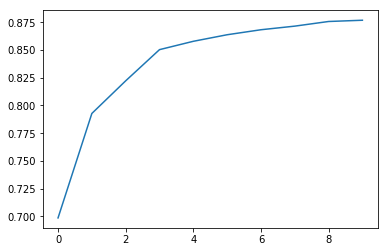

In [130]:
plt.plot([metrics.r2_score(Y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

We see that the more estimators we have (= the more bagging we are doing), the better the model will be able to generalize. As we add more trees, the R^2 improves, but then flattens out a bit. This suggests that we at some point won't be able to improve model performance by adding more trees. It won't get *worse*, but it will lengthen the run time and it won't help.

Estimators are the first hyperparameter to adjust.

J. Howard builds most of his models with 20-30 trees to start. He lets 1000+ estimator models run overnight to see if anything changes, but this is at the end.

In [134]:
# I can test the possibility that adding more trees improves performance.

sales_mod_5b = RandomForestRegressor(n_estimators=20, n_jobs=-1)
sales_mod_5b.fit(X_train, Y_train)
print(display_score(sales_mod_5b))

sales_mod_5c = RandomForestRegressor(n_estimators=30, n_jobs=-1)
sales_mod_5c.fit(X_train, Y_train)
print(display_score(sales_mod_5c))

# A little, not much.

[0.06801858532218982, 0.12856212735683972, 0.9723798746520456, 0.8863813822575448]
None
[0.06294193523929116, 0.1252606819191091, 0.9763489384315084, 0.8921418556067076]
None


### Out-of-bag (OOB) score

Now we want to calculate the error on the training set, but only include the trees in the calculation of a row's error where that row was *not* included in training that tree. 

When we do this, we can see if the model is overfitting without needing a separate validation set. 

For example....in our first tree, some rows did not get used. We could pass those rows through our first tree and see how they do.

In [138]:
sales_mod_6 = RandomForestRegressor(n_estimators=30, n_jobs=-1, oob_score=True)
sales_mod_6.fit(X_train, Y_train)
display_score(sales_mod_6)

# We see that the R**2 of the OOB score is similar to the validation data set, which is good to see.

[0.06081054105846647, 0.12466580647761352, 0.977923603265489, 0.8931638810985104, 0.8373713707704716]
